<a href="https://colab.research.google.com/github/rhwogus/AI_lab/blob/main/LAB_Audio_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
uploaded = files.upload()  # m4a/wav/mp3 파일 올리기
audio_path = list(uploaded.keys())[0]
audio_path

Saving 095522042.m4a to 095522042.m4a


'095522042.m4a'

In [ ]:
def load_audio(path: str):
    """
    Returns:
        waveform: torch.Tensor, shape (channels, num_frames)
        sample_rate: int
    """
    # 1) torchaudio 백엔드가 지원하면 그대로 사용
    try:
        waveform, sr = torchaudio.load(path)  # (C, N)
        return waveform, sr
    except Exception as e:
        # 2) ffmpeg 미포함 등으로 실패하면 librosa로 로드 후 torch 변환
        y, sr = librosa.load(path, sr=None, mono=False)  # mono=False로 원채널 유지
        if y.ndim == 1:
            y = y[np.newaxis, :]  # (1, N)
        waveform = torch.from_numpy(y).float()
        return waveform, sr

waveform, sample_rate = load_audio(audio_path)

# (옵션) 너무 길면 앞 10초만 사용
max_seconds = 10
max_len = int(sample_rate * max_seconds)
if waveform.shape[1] > max_len:
    waveform = waveform[:, :max_len]

waveform.shape, sample_rate

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

(torch.Size([1, 177152]), 44100)

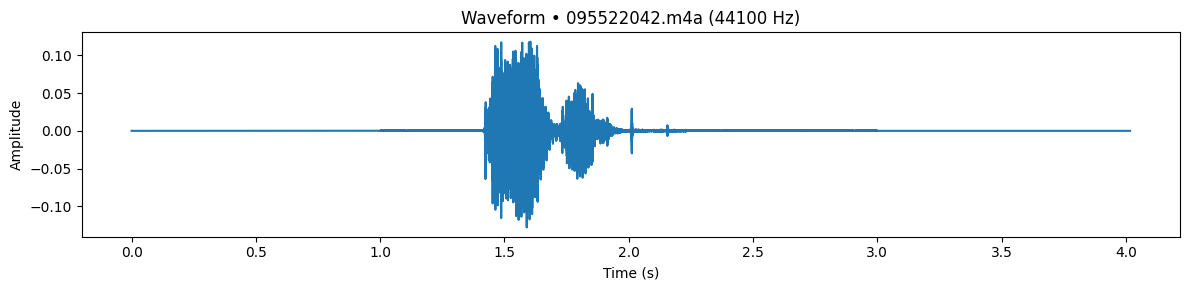

In [ ]:
def plot_waveform(waveform: torch.Tensor, sample_rate: int, title: str = "Waveform"):
    """
    waveform: (C, N)
    """
    num_channels, num_frames = waveform.shape
    t = torch.arange(num_frames) / sample_rate

    plt.figure(figsize=(12, 3 if num_channels == 1 else 5))
    if num_channels == 1:
        plt.plot(t.numpy(), waveform[0].numpy())
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(title)
    else:
        for ch in range(num_channels):
            plt.plot(t.numpy(), waveform[ch].numpy(), label=f"Channel {ch+1}", alpha=0.8)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(title)
        plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

plot_waveform(waveform, sample_rate, title=f"Waveform • {audio_path} ({sample_rate} Hz)")


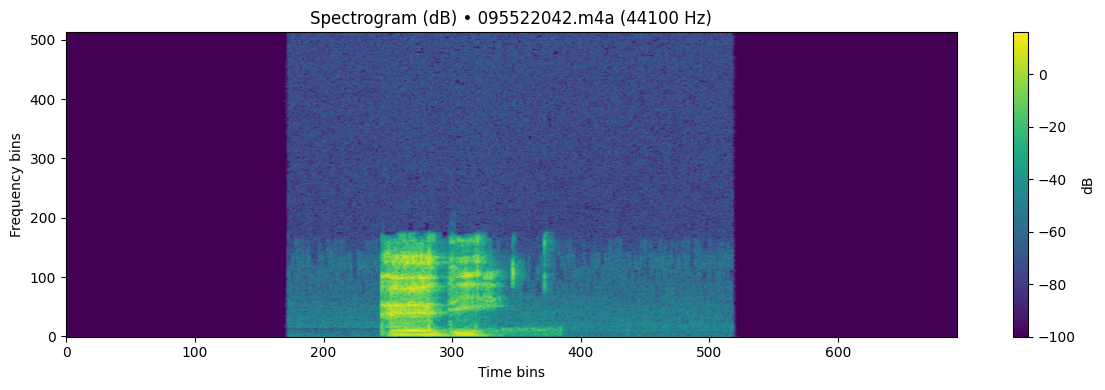

In [ ]:
def plot_spectrogram_db(spec: torch.Tensor, sample_rate: int, title: str = "Spectrogram (dB)"):
    """
    spec: (freq, time) magnitude or power
    - 입력은 선형 스케일 값(>0)이라고 가정하고 dB로 변환해서 그림
    """
    # 숫자 안정성용 eps
    eps = 1e-10
    spec_db = 10.0 * torch.log10(spec.clamp(min=eps))

    plt.figure(figsize=(12, 4))
    plt.imshow(spec_db.numpy(), origin="lower", aspect="auto")
    plt.colorbar(label="dB")
    plt.xlabel("Time bins")
    plt.ylabel("Frequency bins")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# (1) torchaudio 기본 Spectrogram (power)
spec_transform = torchaudio.transforms.Spectrogram(
    n_fft=1024,
    win_length=None,
    hop_length=256,
    power=2.0,          # power spectrogram
    center=True,
)
# 스테레오면 평균해서 단일 채널로
mono = waveform.mean(dim=0, keepdim=True)    # (1, N)

spec = spec_transform(mono)                  # (1, freq, time)
plot_spectrogram_db(spec[0].detach(), sample_rate,
                    title=f"Spectrogram (dB) • {audio_path} ({sample_rate} Hz)")


original: torch.Size([1, 177152]) 44100
down   : torch.Size([1, 64273]) 16000
up     : torch.Size([1, 177153]) 44100


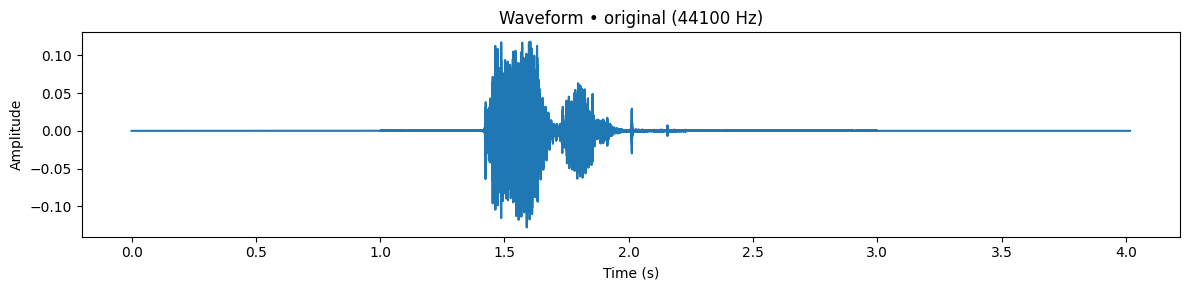

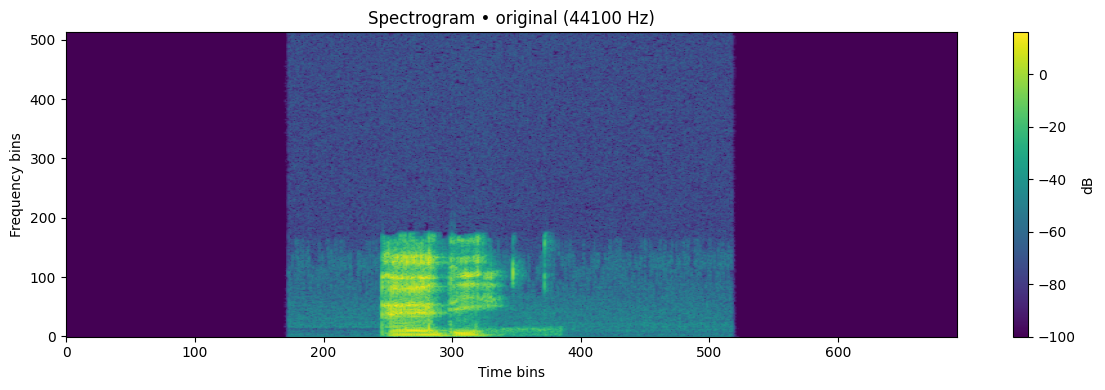

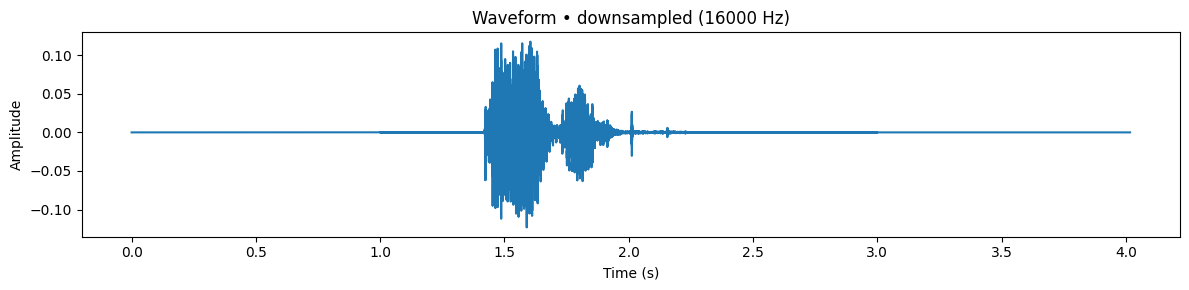

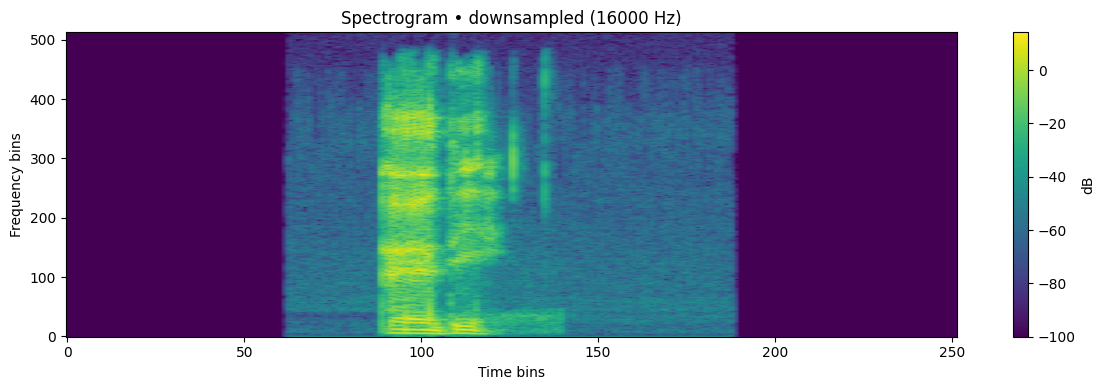

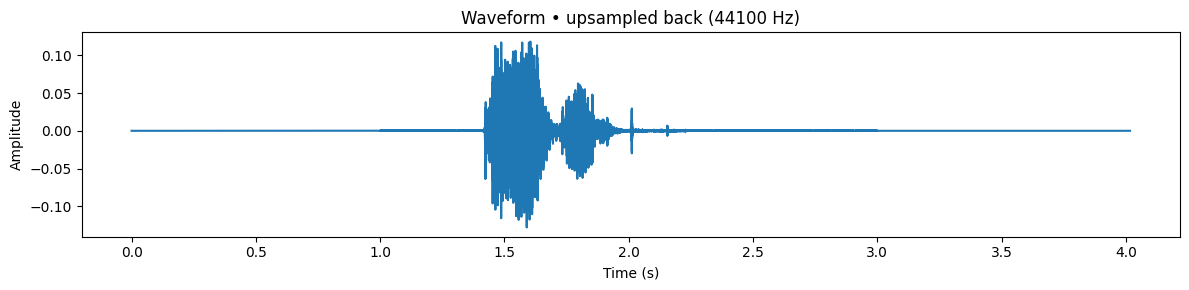

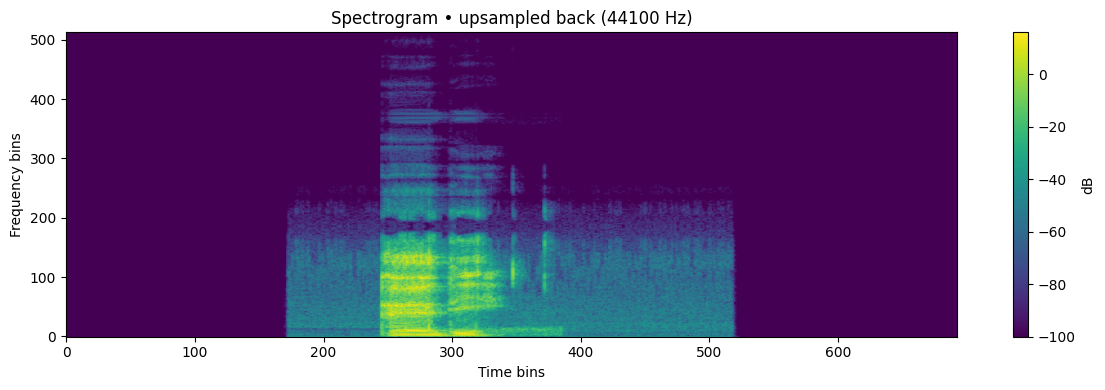

In [ ]:
import torchaudio
import torch
import matplotlib.pyplot as plt

def plot_waveform(waveform: torch.Tensor, sr: int, title="Waveform"):
    t = torch.arange(waveform.shape[1]) / sr
    plt.figure(figsize=(12,3))
    plt.plot(t.numpy(), waveform[0].numpy())
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.title(title); plt.tight_layout(); plt.show()

def plot_spectrogram_db(wave: torch.Tensor, sr: int, title="Spectrogram (dB)"):
    spec = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=256, power=2.0)(wave)  # (1, f, t)
    spec_db = 10*torch.log10(spec.clamp(min=1e-10))
    plt.figure(figsize=(12,4))
    plt.imshow(spec_db[0].numpy(), origin="lower", aspect="auto")
    plt.colorbar(label="dB")
    plt.xlabel("Time bins"); plt.ylabel("Frequency bins")
    plt.title(title); plt.tight_layout(); plt.show()

# --- 스테레오면 모노로
mono = waveform.mean(dim=0, keepdim=True)

# 예시 타깃 샘플레이트
down_sr = 16000
up_sr   = sample_rate      # 원래 SR로 복원

# 1) 다운샘플링: 원본 sample_rate -> down_sr
down_resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=down_sr)
down = down_resampler(mono)

# 2) 업샘플링: down_sr -> 원래 sample_rate
up_resampler = torchaudio.transforms.Resample(orig_freq=down_sr, new_freq=up_sr)
up = up_resampler(down)

print("original:", mono.shape, sample_rate)
print("down   :", down.shape, down_sr)
print("up     :", up.shape, up_sr)

# 시각화 (원본/다운/업)
plot_waveform(mono, sample_rate, title=f"Waveform • original ({sample_rate} Hz)")
plot_spectrogram_db(mono, sample_rate, title=f"Spectrogram • original ({sample_rate} Hz)")

plot_waveform(down, down_sr, title=f"Waveform • downsampled ({down_sr} Hz)")
plot_spectrogram_db(down, down_sr, title=f"Spectrogram • downsampled ({down_sr} Hz)")

plot_waveform(up, up_sr, title=f"Waveform • upsampled back ({up_sr} Hz)")
plot_spectrogram_db(up, up_sr, title=f"Spectrogram • upsampled back ({up_sr} Hz)")
